In [7]:
import algorithm
import numpy as np

In [8]:
import json
import os

def custom_encoder(obj):
    """
    Custom JSON encoder function that converts non-serializable objects.
    Converts:
    - numpy arrays to lists
    - numpy int64 to int
    - numpy float64 to float
    """
    if isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, np.integer):
        return int(obj)
    elif isinstance(obj, np.floating):
        return float(obj)
    elif isinstance(obj, np.inf):
        return "np.inf"
    else:
        # This will raise a TypeError for unknown types
        raise TypeError(f"Object of type '{obj.__class__.__name__}' is not JSON serializable")

def save_partial(results, citysize, range):

    x = 0
    while True:
        file_path = f"results{citysize}_{range}_{x}.json"
        if not os.path.exists(file_path):
            break
        x += 1

    # Dumping the nested_dict to a json file with custom encoding
    with open(file_path, "w") as json_file:
        json.dump(results, json_file, default=custom_encoder)

    print(f"Results saved to JSON file successfully as {file_path}")

In [9]:
def mutate_matrix(_matrix, _upper, _print):
    matrix = _matrix.copy()
    number1, number2 = 0, 0

    while number1 == number2:
        number1, number2 = np.random.randint(0,matrix.shape[0]), np.random.randint(0,matrix.shape[0])
    previous_number = matrix[number1,number2]
    while matrix[number1,number2] == previous_number:
        matrix[number1,number2] = np.random.randint(1,_upper)
    if _print:
        print(_matrix[number1,number2].round(1), "at", (number1,number2), "becomes", matrix[number1,number2].round(1))

    return matrix

In [10]:
def experiment_nohill(_cities, _ranges, _mutations):
    for citysize in _cities:
        for rang in _ranges:
            range_results = {}
            hardest = 0
            matrix = np.random.randint(1,range,((citysize, citysize)))
            for x in range(citysize):
                matrix[x, x] = np.inf
            for j in range(_mutations):
                iterations, optimal_tour, optimal_cost = algorithm.get_minimal_route(matrix)
                range_results[j] = (iterations, hardest, optimal_tour, optimal_cost, matrix)
                if iterations > hardest:
                    hardest = iterations
                matrix = mutate_matrix(matrix, rang)
            save_partial(range_results, citysize, rang)

In [11]:
def experiment(_cities, _ranges, _mutations):
    for citysize in _cities:
        for rang in _ranges:
            range_results = {}
            hardest = 0
            
            # initialize the matrix with ints, but convert it to a floating-point type to enable np.inf
            matrix = np.random.randint(1,rang,((citysize, citysize))).astype(float)
            for x in range(citysize):
                matrix[x, x] = np.inf
            hardest_matrix = matrix
            
            for j in range(_mutations):
                iterations, optimal_tour, optimal_cost = algorithm.get_minimal_route(matrix)
                # save results of interest
                # in order: iterations Little took on this instance, hardest instance so far, 
                # optimal_tour, optimal_cost, matrix
                range_results[j] = (iterations, hardest, optimal_tour, optimal_cost, matrix)
                
                # hillclimb
                if iterations > hardest:
                    hardest_matrix = matrix
                    matrix = mutate_matrix(hardest_matrix, rang, False)
                    hardest = iterations
                else:
                    matrix = mutate_matrix(hardest_matrix, rang, False)
            
            # save to json file
            save_partial(range_results, citysize, rang)

In [37]:
experiment([10,12], [10,1000], 500)

KeyboardInterrupt: 

In [38]:
def custom_decoder(obj):
    """
    Custom decoder function that converts specific JSON values back to their original types.
    Converts:
    - 'Infinity' to np.inf
    """
    if isinstance(obj, dict):
        for key, value in obj.items():
            if value == "Infinity":
                obj[key] = np.inf
            # elif isinstance(value, list):
                # Convert lists back to arrays
                # obj[key] = np.array(value)
            elif isinstance(value, dict):
                obj[key] = custom_decoder(value)
    elif isinstance(obj, list):
        for i, value in enumerate(obj):
            if value == "Infinity":
                obj[i] = np.inf
            # elif isinstance(value, list):
                # obj[i] = np.array(value)
            elif isinstance(value, dict):
                obj[i] = custom_decoder(value)
    return obj


def load_result(file_path):

  # Loading the JSON file with custom decoding
  with open(file_path, "r") as json_file:
      loaded_results = json.load(json_file, object_hook=custom_decoder)

  return loaded_results

In [42]:
cities = [10,20]

uberdict = {}

for i in cities:
  path = f"Results/deprecated/results{i}_10and100_0.json"
  loaded = load_result(path)
  uberdict[i] = loaded

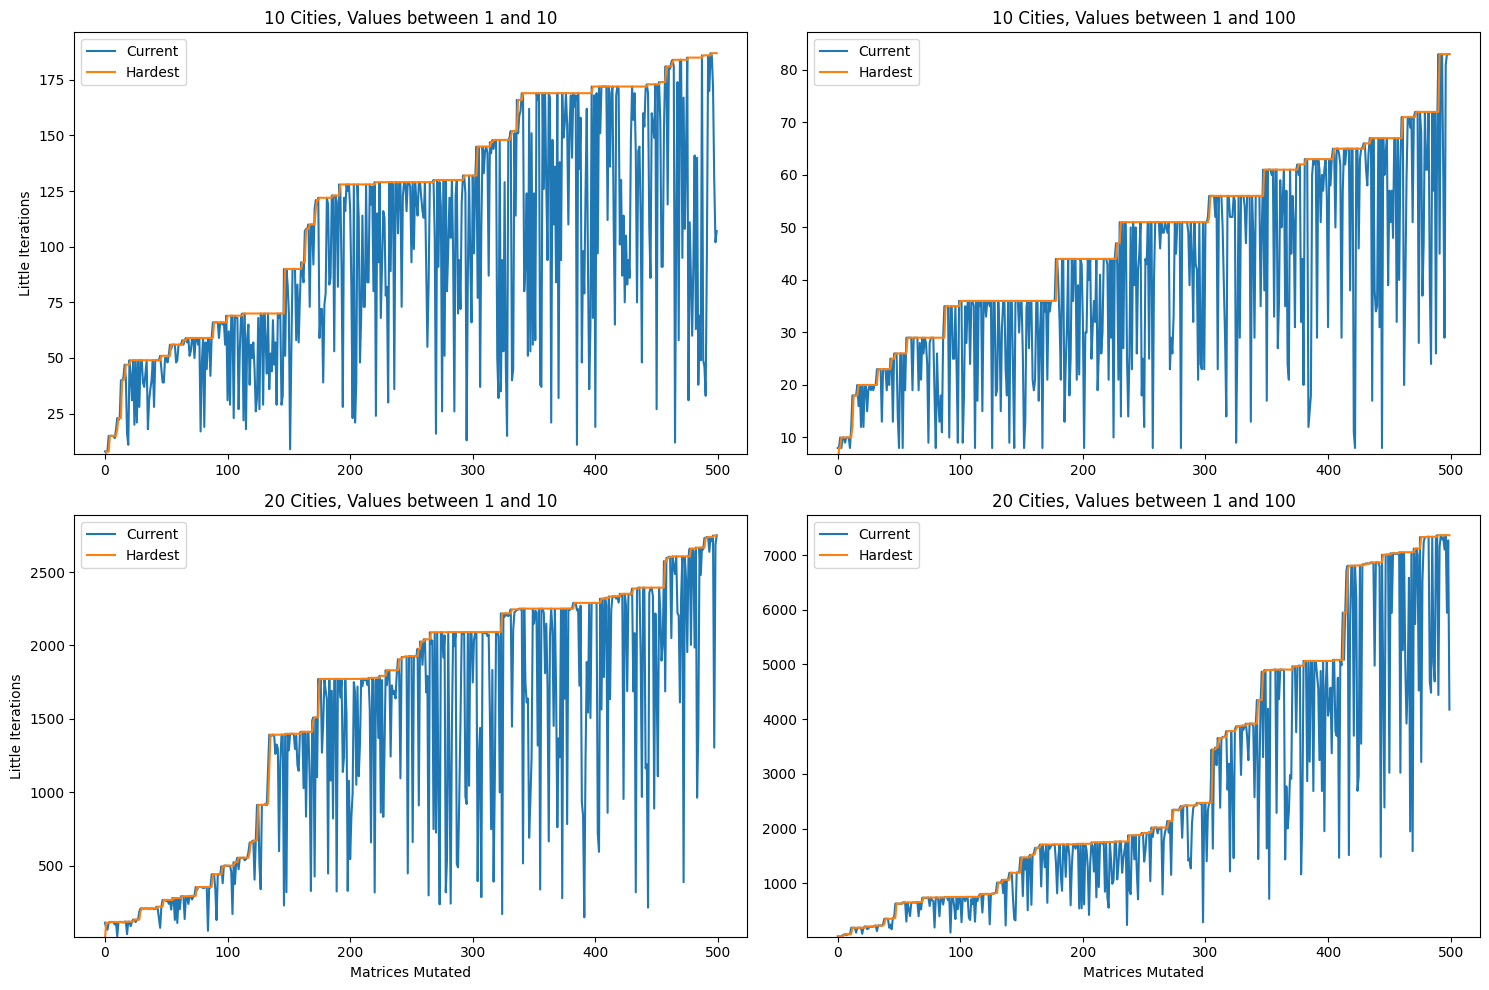

In [43]:
import matplotlib.pyplot as plt

num_cities = len(uberdict)  # Number of different cities
num_result_ranges = len(next(iter(uberdict.values())))  # Number of different result ranges per city
subplot_rows = num_cities
subplot_cols = num_result_ranges

fig, axs = plt.subplots(subplot_rows, subplot_cols, figsize=(15, 10))  # Adjust the figsize as necessary

for city_idx, (city_range, city_results) in enumerate(uberdict.items()):
    for result_idx, (result_range, data) in enumerate(city_results.items()):
        ax = axs[city_idx, result_idx] if subplot_rows > 1 and subplot_cols > 1 else axs[max(city_idx, result_idx)]
        
        # Extracting keys and values for the current city and result range
        x_values = list(data.keys())
        y_values_0 = [values[0] for values in data.values()]  # First set of values
        y_values_1 = [values[1] for values in data.values()]  # Second set of values

        # Plotting on the respective subplot
        ax.plot(x_values, y_values_0, label='Current')
        ax.plot(x_values, y_values_1, label='Hardest')

        ax.set_xticks(list(range(0,600,100)))
        ax.set_xticklabels(list(range(0,600,100)))

        ax.set_ylim(bottom=min(y_values_0)-(min(y_values_0)/7))
        if result_idx == 0:
          ax.set_ylabel('Little Iterations')
        if city_idx == 1:
          ax.set_xlabel('Matrices Mutated')
        ax.set_title(f'{city_range} Cities, Values between 1 and {result_range}')
        ax.legend()

plt.tight_layout()
plt.show()

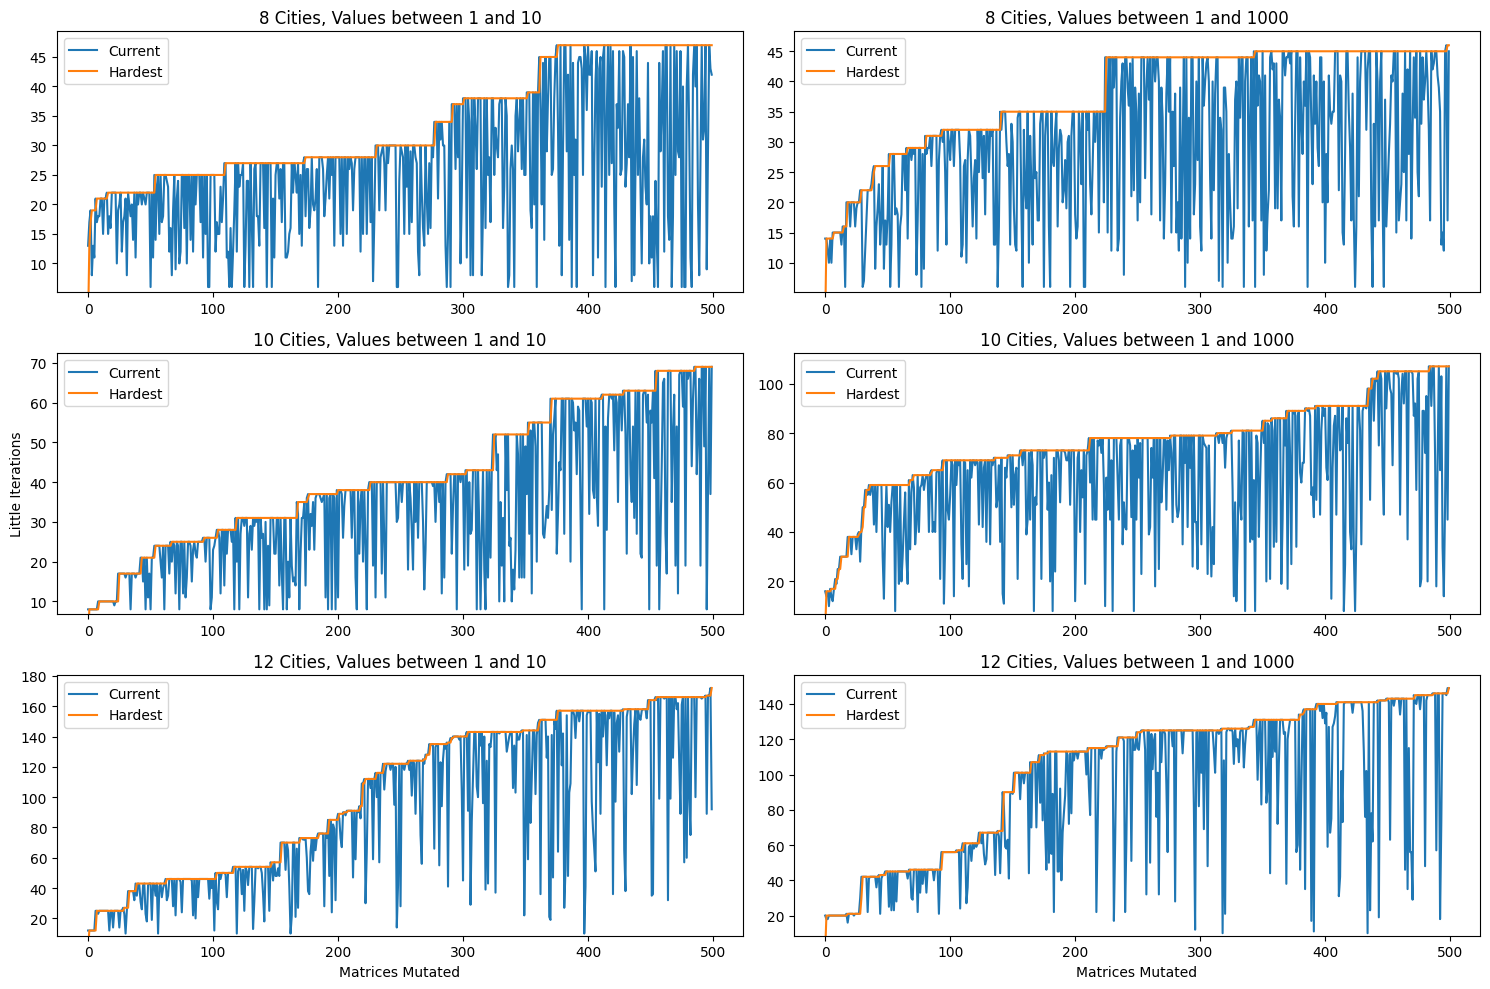

In [44]:
cities = [10, 12]
ranges = [10, 1000]

# Assuming a subplot for each city and range combination
subplot_rows = len(cities)
subplot_cols = len(ranges)

fig, axs = plt.subplots(subplot_rows, subplot_cols, figsize=(15, 10))  # Adjust figsize as necessary

for i, city in enumerate(cities):
    for j, range_val in enumerate(ranges):
        path = f"Results/results{city}_{range_val}_0.json"
        loaded = load_result(path)
        
        # Assuming 'loaded' contains the plotting data similar to your original 'results' structure
        # You may need to adjust the access pattern based on the actual structure of 'loaded'
        x_values = list(loaded.keys())
        y_values_0 = [values[0] for values in loaded.values()]  # Adjust based on actual data structure
        y_values_1 = [values[1] for values in loaded.values()]  # Adjust based on actual data structure
        
        # Determine the correct axis for plotting
        if subplot_rows > 1 and subplot_cols > 1:
            ax = axs[i, j]
        elif subplot_rows > 1:
            ax = axs[i]
        else:
            ax = axs[j]
        
        # Plotting on the respective subplot
        ax.plot(x_values, y_values_0, label='Current')
        ax.plot(x_values, y_values_1, label='Hardest')

        ax.set_xticks(list(range(0,600,100)))
        ax.set_xticklabels(list(range(0,600,100)))

        ax.set_ylim(bottom=min(y_values_0)-(min(y_values_0)/7))
        if i == 1 and j == 0:
          ax.set_ylabel('Little Iterations')
        if i == 2:
          ax.set_xlabel('Matrices Mutated')
        ax.set_title(f'{city} Cities, Values between 1 and {range_val}')
        ax.legend()
        
plt.tight_layout()
plt.show()

10 cities, between 1 and 10, pearson statistic: -0.505, Pvalue: 0.0
10 cities, between 1 and 1000, pearson statistic: -0.287, Pvalue: 1e-10
20 cities, between 1 and 10, pearson statistic: 0.426, Pvalue: 0.0
20 cities, between 1 and 1000, pearson statistic: 0.667, Pvalue: 0.0
Pvalue rounded to 10 decimals


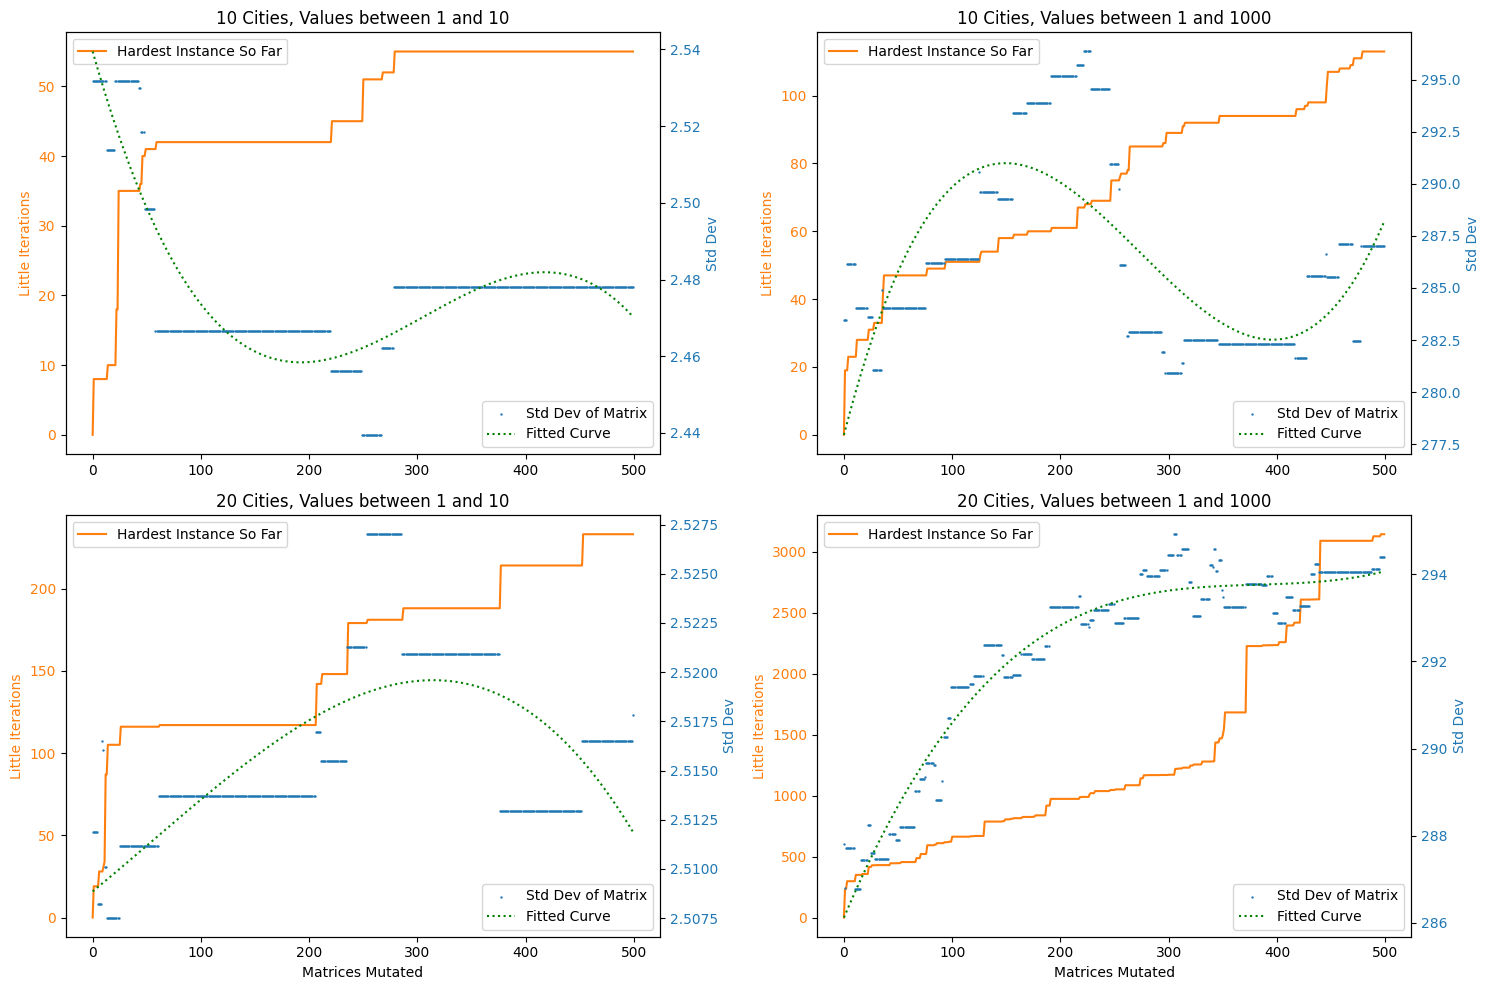

In [ ]:
from scipy.stats import pearsonr

cities = [10, 20]
ranges = [10, 1000]

subplot_rows = len(cities)
subplot_cols = len(ranges)

fig, axs = plt.subplots(subplot_rows, subplot_cols, figsize=(15, 10)) 

for i, city in enumerate(cities):
    for j, range_val in enumerate(ranges):
        path = f"Results/results{city}_{range_val}_0.json"
        loaded = load_result(path)

        # sort
        # loaded = dict(sorted(loaded.items(), key=lambda item: item[1][0]))
        
        # matrices of hardest instances at every mutation
        hardest_matrices = []
        for values in loaded.values():
            if values[0] > values[1]:
                hardest_matrices.append(values[4])
            else:
                hardest_matrices.append(hardest_matrices[-1])

        y_values_std = np.fromiter((np.std(np.ma.masked_invalid(x)) for x in hardest_matrices), float)
        # y_values_std = [np.std(np.ma.masked_invalid(values[4])) for values in loaded.values()]
        y_values = np.fromiter((values[1] for values in loaded.values()), float)
        x_values = list(range(len(y_values)))
        
        if subplot_rows > 1 and subplot_cols > 1:
            ax = axs[i, j]
        elif subplot_rows > 1:
            ax = axs[i]
        else:
            ax = axs[j]

        # Plot the sorted current instances
        color = 'tab:orange'
        ax.plot(x_values, y_values, label='Hardest Instance So Far', color=color)
        ax.set_ylabel('Little Iterations', color=color)
        ax.tick_params(axis='y', labelcolor=color)

        # Create a twin y-axis to plot the standard deviation
        ax2 = ax.twinx()
        color = 'tab:blue'
        ax2.scatter(x_values, y_values_std, label='Std Dev of Matrix', color=color, s=0.5)
        ax2.set_ylabel('Std Dev', color=color)
        ax2.tick_params(axis='y', labelcolor=color)

        # Plot the fitted curve
        poly_deg = 3
        ax2.plot(x_values, np.poly1d(np.polyfit(x_values, y_values_std, poly_deg))(x_values), label='Fitted Curve', color='green', linestyle=':')

        # ax.set_xticks(list(range(0,600,100)))
        # ax.set_xticklabels(list(range(0,600,100)))

        #TODO set bottom ylim to hardness of easiest matrix
        # ax.set_ylim(bottom=min(y_values_0)-(min(y_values_0)/7))
        
        if i == 1:
          ax.set_xlabel('Matrices Mutated')
        ax.set_title(f'{city} Cities, Values between 1 and {range_val}')
        ax.legend()
        ax2.legend(loc='lower right')
        print(f"{city} cities, between 1 and {range_val}, pearson statistic: {round(pearsonr(y_values_std, y_values)[0],3)}, Pvalue: {round(pearsonr(y_values_std, y_values)[1],10)}")
print("Pvalue rounded to 10 decimals")
        
plt.tight_layout()
plt.show()

In [14]:
import matplotlib.pyplot as plt

num_cities = len(results)  # Number of different cities
num_result_ranges = len(next(iter(results.values())))  # Number of different result ranges per city
subplot_rows = num_cities
subplot_cols = num_result_ranges

fig, axs = plt.subplots(subplot_rows, subplot_cols, figsize=(15, 10))  # Adjust the figsize as necessary

for city_idx, (city_range, city_results) in enumerate(results.items()):
    for result_idx, (result_range, data) in enumerate(city_results.items()):
        ax = axs[city_idx, result_idx] if num_cities > 1 and num_result_ranges > 1 else axs[max(city_idx, result_idx)]
        
        # Extracting keys and values for the current city and result range
        x_values = list(data.keys())
        y_values_0 = [values[0] for values in data.values()]  # First set of values
        y_values_1 = [values[1] for values in data.values()]  # Second set of values
        
        # Plotting on the respective subplot
        ax.plot(x_values, y_values_0, label='Current')
        ax.plot(x_values, y_values_1, label='Hardest')
        
        ax.set_ylim(bottom=min(y_values_0)-(min(y_values_0)/7))
        ax.set_xlabel('Matrices Mutated')
        ax.set_ylabel('Little Iterations')
        ax.set_title(f'{city_range} Cities, Values between 1 and {result_range}')
        ax.legend()

plt.tight_layout()
plt.show()

NameError: name 'results' is not defined

In [ ]:
test_matrix = np.array([
      [np.inf, 6, 6, 7, 30, 26],
      [7, np.inf, 16, 1, 30, 25],
      [20, 13, np.inf, 35, 5, 0],
      [21, 16, 25, np.inf, 18, 18],
      [12, 46, 27, 48, np.inf, 5],
      [23, 5, 5, 9, 5, np.inf]
    ])

iterations, optimal_tour, optimal_cost = get_minimal_route(test_matrix)
iterations, optimal_tour, optimal_cost